## **Machine Learning - WNBA Playoffs Prediction**
This notebook will focus on the undestanding of the data. We will be using SQLite to store the data due to its scalability & the fact that it's a relational schema.

https://docs.python.org/3/library/sqlite3.html

Import sqlite3 and connect to database file

### **Imports**

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import feature_selection as fs
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
import prep_utils as pu
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pointbiserialr
from sklearn.feature_selection import RFE
import warnings

warnings.filterwarnings("ignore")
PAST_YEARS = 2
TEST_YEAR = 10
KAGGLE_TEST_YEAR = 11

### **Database Connection Setup**
The initial intake of data was loaded into a SQLite3 database. Further, in order to improve the effectiveness of further data transformation procedures, a calculated choice was taken to convert the data into a Pandas dataframe. Furthermore, Year 11 competition data has been added to the database, augmenting it.


In [2]:
db = sqlite3.connect("db/ac.db")
db_cur = db.cursor()

[df_awards, df_coaches, df_players_teams, df_players, df_series_post, df_teams_post, df_teams] = pu.db_to_pandas(db)

### **Data Preparation**

#### **Preparing Teams Dataframe**

+ Removed features deemed not important such as: arena, lgID, divID.
+ Removed features that were irrelevant (always have the same value for all entries)
+ Replaced features of the format feature_made & feature_attempted by its success rate; (3points, fieldgoal, regular_winrate, playoff_winrate)
+ Replaced FirstRound, Semis & Final by the teams playoff rank

In [3]:
df_new_teams = pu.prepare_teams(df_teams,df_teams_post, PAST_YEARS)
df_new_teams = fs.fs_teams(df_new_teams)
df_new_teams = pu.playoff_rank(df_new_teams,df_teams, PAST_YEARS)
#df_team_results = df_new_teams[["year","tmID","confID","playoff","rank","team_playoffs_count","playoff_rank"]]
df_team_results = df_new_teams[["year","tmID","confID","playoff","rank","team_playoffs_count","playoff_rank","Winrate","PO_Winrate"]]

Dropping divID in Teams...
Dropping ldID in Teams...
Dropping seeded in Teams...
Dropping tmORB, tmDRB, tmTRB, opptmORB, opptmDRB, opptmTRB in Teams...
Dropping homeW, homeL, awayW, awayL, confW, confL, attend, name, franchID & arena in Teams...
Converting Target PLAYOFF to binary onTeams...
Creating attribute winrate Teams...
Dropping won & lost in Teams...
Creating attribute PlayOffs winrate Teams...


#### **Preparing Coaches Dataframe**

+ Replaced Wins/Losses by winrate. For both regular season & playoff
+ Created Coach Award Amount Feature
+ Created Coach PlayOff Appearances Feature

In [4]:
df_new_coaches = pu.prepare_coaches(df_coaches, df_awards,PAST_YEARS)
df_new_coaches = pu.group_coaches(df_new_coaches)

df_new_coaches.drop("coachID", axis = 1, inplace = True)

df_final_coaches = df_new_coaches.copy()
df_final_coaches.columns = df_final_coaches.columns.str.lower()


Dropping Attribute lgID in Coaches...
Creating attribute coach previous regular season win ratio...
Creating attribute coach playoffs win ratio...
Creating attribute coach playoffs count...
Creating attribute coach awards count...
Dropping attribute post_wins..
Dropping attribute post_losses..
Dropping attribute won..
Dropping attribute lost..

Coaches Null Verification:
year                    0
tmID                    0
coachID                 0
coach_reg_wr            0
coach_po_wr             0
coach_playoffs_count    0
coach_awards            0
dtype: int64


#### **Preparing Players Dataframe**
+ Created Player Award Amount Feature
+ Replaced features of the format feature_made & feature_attempted by its success rate;
+ In order to reduce the dataset dimensionality, we also aggregated the metrics that were common to both Regular Season & Playoffs in a **weighted** manner.


In [5]:
df_new_players_teams = pu.prepare_player_teams(df_players_teams,df_awards,PAST_YEARS)

Dropping Attribute lgID in Players_Teams...
Created Attribute Player_Awards in Players_Teams...


#### **Created 2 Team Ratings:**
+  One rated the players performance from the previous seasons. The goal is to assess the roster's capacity for consistent performance across a range of seasons, player growth, and the team's general quality and stability.

+ A rating that evaluates whether the team has had a roster of talented players in previous years. The goal of this rating is to assess the team's historical trend of acquiring or keeping high-caliber players as well as to provide a quantitative measure of the team's general quality and stability.

In [6]:
# How the team performed in the previous years
previous_team_ratings, df_new_players_team = pu.final_team_ratings(df_players_teams,df_awards, df_players, df_teams, PAST_YEARS)

# How the players performed in the previous years
previous_team_player_ratings = pu.final_player_team_ratings(df_teams, df_new_players_team, df_players, PAST_YEARS,df_new_players_teams[df_new_players_teams['year'] == KAGGLE_TEST_YEAR])

#### **Merging all dataframes into one final dataframe**

Although initially we are given a relational schema, in order for the machine learning models work with our data we will be merging the relevant data into a single dataframe. This consolidation not only streamlines the data for machine learning models but also facilitates a comprehensive analysis of the interplay between various features on a global scale. By merging the data based on the relational schema's key relationships, we ensure that the connections and dependencies within the dataset are accurately represented. This unified approach enables us to uncover patterns and correlations that might have been obscured when the data was compartmentalized in separate dataframes. In essence, our goal is to create a cohesive foundation that allows for a more nuanced understanding of how different features influence each other, offering insights that were previously elusive due to the fragmented nature of the dataset.

In [7]:
df_players = df_new_players_teams.copy()
df_players = fs.fs_players(df_players,0.2)
df_players = df_players[df_players['year'] != 1]


df_team_results.columns = df_team_results.columns.str.lower()
previous_team_player_ratings.columns = previous_team_player_ratings.columns.str.lower()


merged_data = pd.merge(df_players, df_team_results, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, df_final_coaches, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, previous_team_ratings, on=['tmid', 'year'], how='left')
merged_data = pd.merge(merged_data, previous_team_player_ratings, on=['tmid', 'year'], how='left')


### **Feature Selection**
During the process of **feature engineering**, certain derived attributes demonstrated an inherent capacity to diminish the dataset's dimensionality, consolidating multiple attributes into singular entities. Noteworthy exemplars of this phenomenon are most of the ratios e.g winrate & metric_success rate.

In order to optimize the efficiency and relevance of the dataset, a strategic undertaking in feature selection was embarked upon. This involved a meticulous examination of the interrelationships between various features, facilitated by the utilization of a **correlation matrix**. The primary objective was to discern redundancy among features and subsequently identify candidates for removal.

Further refinement of the dataset was achieved through the employment of the **point biserial correlation test**, a discerning tool instrumental in isolating features exhibiting minimal correlation with the target variable. Features failing to meet the requisite correlation criteria were systematically excluded from consideration.

Subsequently, the Recursive Feature Elimination (RFE) methodology was invoked to conduct a discriminating assessment of the feature ensemble. Through this iterative process, RFE identified and retained features deemed most consequential and germane to the dataset's predictive performance.


#### **Correlation Matrix**
We'll use a correlation matrix to gauge the relationships between continuous attributes. This tool provides a quantitative measure of correlation, helping us identify patterns and dependencies. By assessing correlation coefficients, we can understand how variables interact, crucial for refining our machine learning models and making informed decisions in development.

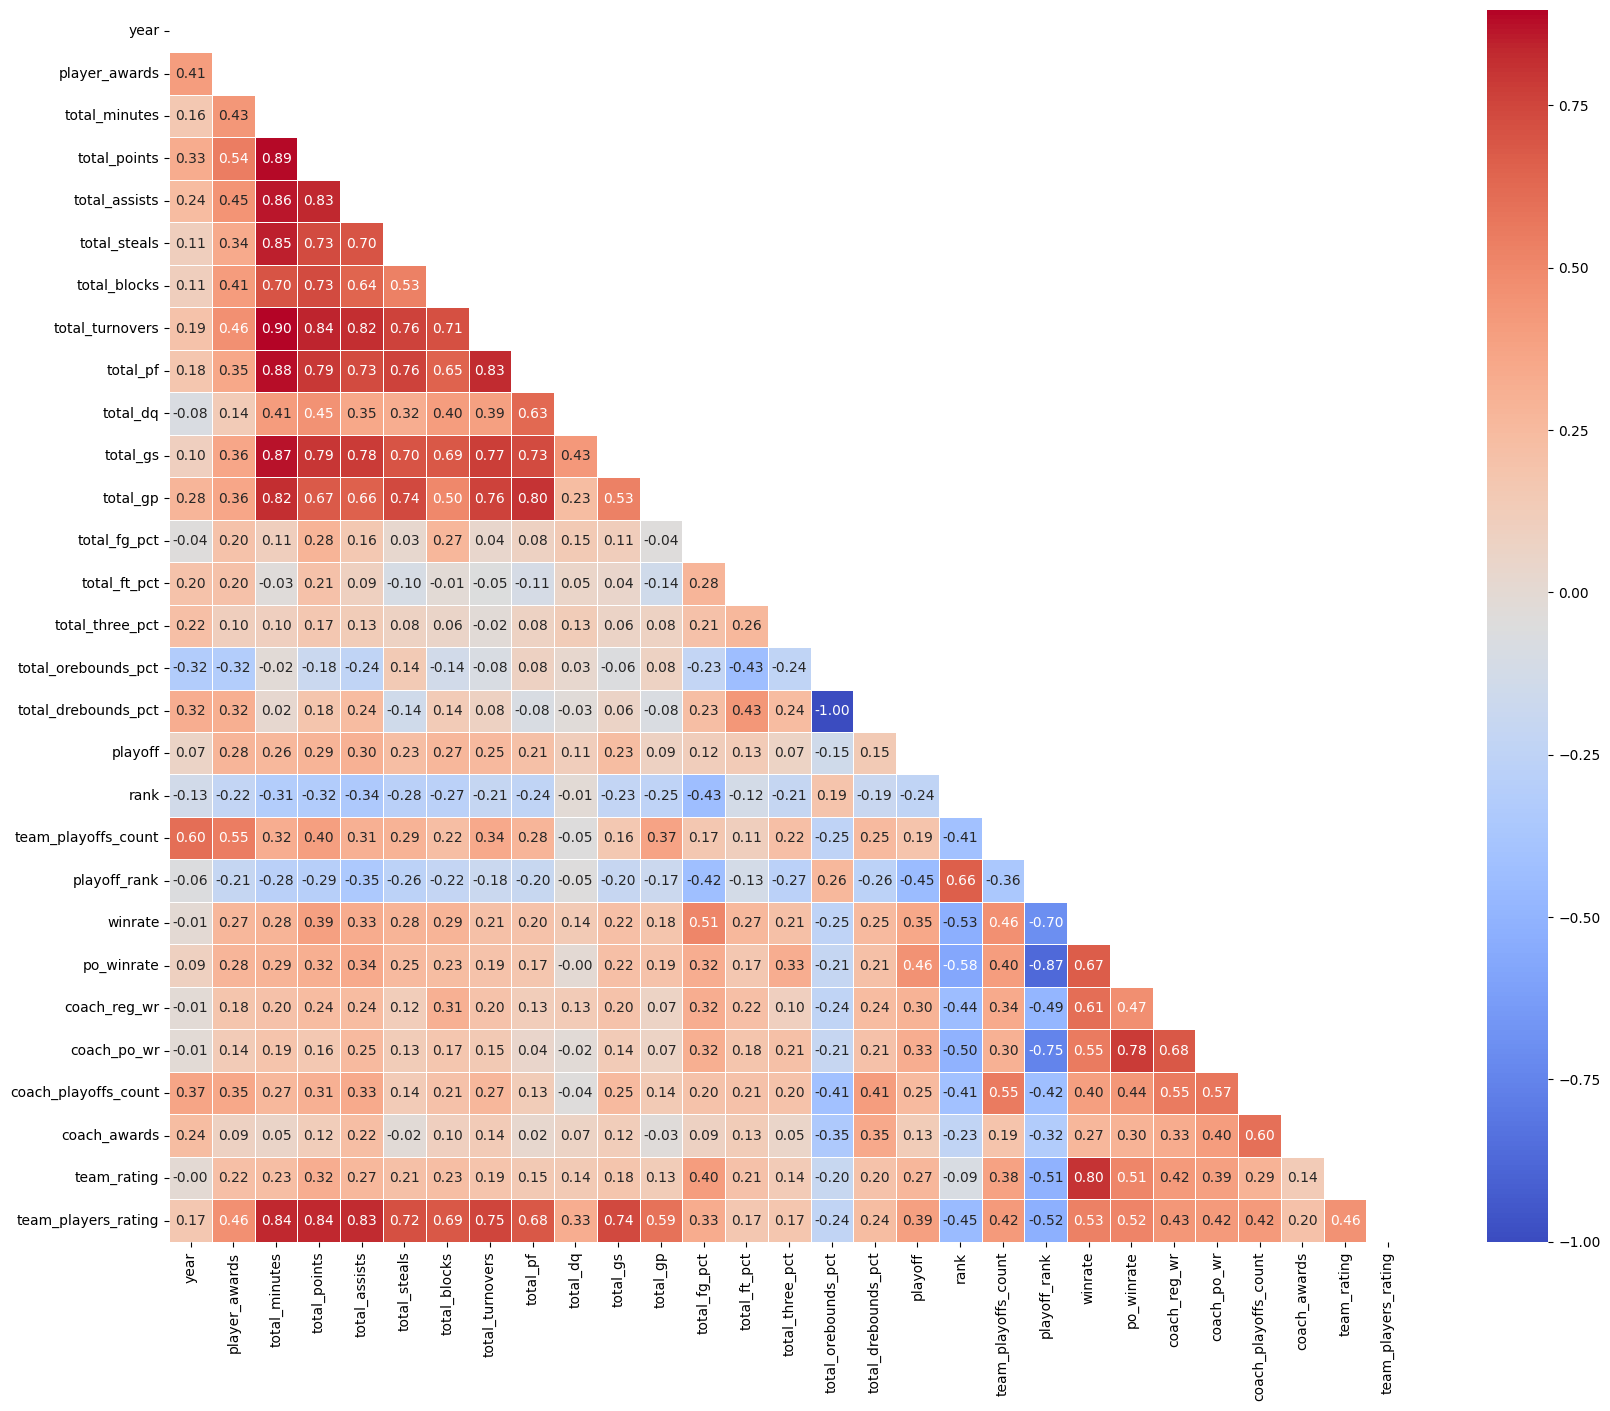


Pairs with high correlation (> 0.75):
total_minutes and total_points: 0.89
total_minutes and total_steals: 0.85
total_minutes and total_turnovers: 0.90
total_minutes and total_pf: 0.88
total_points and total_turnovers: 0.84
total_assists and total_minutes: 0.86
total_assists and total_points: 0.83
total_assists and total_turnovers: 0.82
total_assists and total_gs: 0.78
total_steals and total_turnovers: 0.76
total_pf and total_points: 0.79
total_pf and total_steals: 0.76
total_pf and total_turnovers: 0.83
total_gs and total_minutes: 0.87
total_gs and total_points: 0.79
total_gs and total_turnovers: 0.77
total_gp and total_minutes: 0.82
total_gp and total_turnovers: 0.76
total_gp and total_pf: 0.80
total_drebounds_pct and total_orebounds_pct: -1.00
playoff_rank and po_winrate: -0.87
coach_po_wr and playoff_rank: -0.75
coach_po_wr and po_winrate: 0.78
team_rating and winrate: 0.80
team_players_rating and total_minutes: 0.84
team_players_rating and total_points: 0.84
team_players_rating a

In [8]:
data1_10 = merged_data[merged_data['year'] != 11]
fs.correlation_matrix(data1_10, 0.75)

Initially, we planned to automatically delete one feature from pairs with good correlation (> 0.9). Upon deeper examination, this strategy turned out to be less "viable". A pair should be chosen for retention or discarding based on predetermined standards, taking into account the particular context of the dataset. Even when two qualities are highly correlated, their individual and combined effects on other aspects might differ. It becomes necessary to do a detailed analysis to make sure that our choices for data preparation take into account the complexities of the dataset in question and to prevent us from missing important information.


#### **Point Bisserial Correlation**
In order to evaluate the relationship between the **continuous** variables and the **binary** target (playoff), we will apply a statistical measure designed to account for these kinds of situations. This approach considers the connection between a continuous and a binary variable, offering important new information about that relationship. We can better understand how the continuous attributes affect the playoff result by doing this test to find patterns and linkages in the data. By using this analytical method, we want to better understand the underlying dynamics and determinants that determine whether a team makes the playoffs or not given its attributes.

In [9]:
fs.bisserial_corr(data1_10)

po_winrate: 45.62% correlation
playoff_rank: 45.04% correlation
team_players_rating: 39.26% correlation
winrate: 34.91% correlation
coach_po_wr: 32.54% correlation
total_assists: 29.99% correlation
coach_reg_wr: 29.64% correlation
total_points: 28.92% correlation
player_awards: 27.79% correlation
team_rating: 27.00% correlation
total_blocks: 26.97% correlation
total_minutes: 26.44% correlation
total_turnovers: 25.48% correlation
coach_playoffs_count: 24.50% correlation
rank: 24.16% correlation
total_gs: 23.08% correlation
total_steals: 22.88% correlation
total_pf: 21.06% correlation
team_playoffs_count: 19.10% correlation
total_drebounds_pct: 14.76% correlation
total_orebounds_pct: 14.76% correlation
total_ft_pct: 13.38% correlation
coach_awards: 12.93% correlation
total_fg_pct: 11.87% correlation
total_dq: 11.23% correlation
total_gp: 8.83% correlation
total_three_pct: 7.22% correlation


The majority of attributes demonstrate a statistically significant correlation, save for **total_ft_pct** and **total_three_pct**. This anomaly may be attributed to their representation as percentages, since the correlation test predominantly accounts for linear relationships hence their values. Despite registering low correlation coefficients, these features remain pertinent, as their relevance is nuanced and contextually contingent, underscoring the importance of considering non-linear dynamics in data interpretation.

### **Algorithms and Model Training**
From the Exploratory Data Analysis we can easily conclude that our dataset despite not having many data itself (~ 10 WNBA Seasons) is pretty balanced (56% - 44%).

We'll use **StandardScaler** to scale the features. Scaling is an important preprocessing step that ensures all characteristics have a comparable scale and range. The characteristics are transformed by StandardScaler by removing the mean and dividing by the standard deviation, resulting in a distribution with a mean of 0 and a standard deviation of 1. This scaling strategy is very effective for algorithms based on distance, such as k-nearest neighbors and support vector machines.

We'll employ **Recursive Feature Elimination** (RFE) to identify the most influential features for each model. We'll set a minimum acceptable number of features, ensuring a balance between model complexity and performance. This systematic approach aims to enhance model interpretability and efficiency by retaining the most informative attributes while meeting our specified criteria.

To evaluate the performance of the different models a thorough evaluation will be conducted using a range of metrics. **Accuracy**, measuring the overall correctness of predictions, provides a broad perspective on model performance. **Recall**, emphasizing the ability to capture all relevant instances, is crucial for scenarios where identifying true positives is paramount. **F1-measure**, which combines precision and recall, offers a balanced assessment, especially valuable when there's a need to strike a harmony between false positives and false negatives. **AUC**, or Area Under the Curve, assesses the model's ability to distinguish between positive and negative instances across various thresholds, providing insights into its overall discriminatory power. Through the comprehensive analysis of these metrics, we aim to gain a nuanced understanding of each model's strengths and weaknesses.

We will apply **GridSearch** to fine tune each model and find the parameters that generate the best results.

To choose the optimal model for **Kaggle** submission, we'll rigorously test each one across years 2 to 10. By averaging the accuracies over this period, we aim to identify a model that not only performs well across different time points but also maintains consistent effectiveness.

Algorithms tested:
- **Random Forest**
- **Logistic Regression**
- **K Nearest Neighbours**
- **Gradient Boosting**
- **Support Vector Machines**


#### **Dividing the dataset in both train & test sets**


We'll transform the remaining non-numerical attributes into integers, a step favored by models for optimal performance with numerical inputs. Employing a label encoder, each distinct **teamID** & **confID** will be assigned a unique integer. Following this encoding, we'll partition the dataset into training and testing sets, laying the groundwork for effective model evaluation and prediction.

We also use **Standard Scaler** to scale the data.

The train & test data is divided in the following format:
- The training data will be all years prior to the year we want to predict
- The test data will be the year we want to predict

In [10]:
label_encoder = LabelEncoder()
scaler = StandardScaler()
KAGGLE_YEAR = merged_data[merged_data['year'] == KAGGLE_TEST_YEAR].drop('playoff', axis=1)
merged_data['tmid'] = label_encoder.fit_transform(merged_data['tmid'])
merged_data['confid'] = label_encoder.fit_transform(merged_data['confid'])

x = merged_data.drop('playoff', axis=1)
y = merged_data['playoff']

x = scaler.fit_transform(x)



x_train = merged_data[merged_data['year'].between(0, TEST_YEAR - 1)].drop('playoff', axis=1)
y_train = merged_data[merged_data['year'].between(0, TEST_YEAR - 1)]['playoff']

x_test = merged_data[merged_data['year'] == TEST_YEAR].drop('playoff', axis=1)
y_test = merged_data[merged_data['year'] == TEST_YEAR]['playoff']



#### **Initial Testing on Year 10**

Random Forest


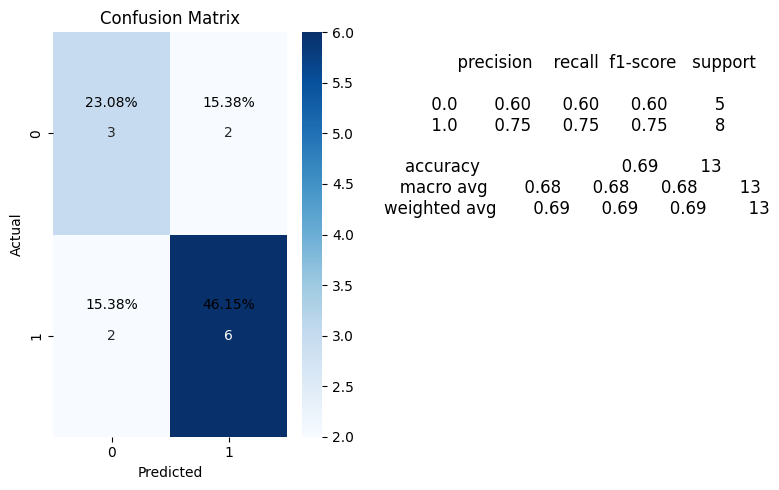

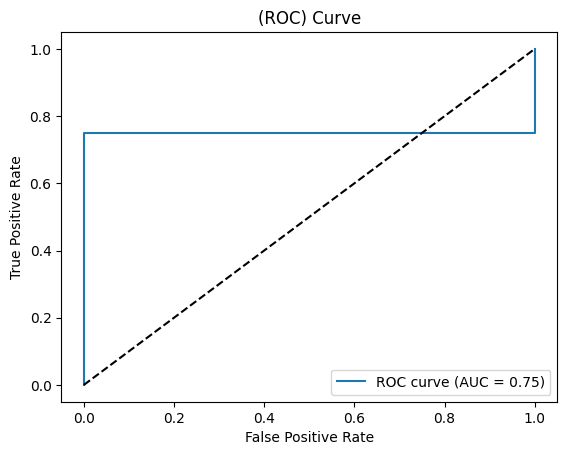

Logistic Regression


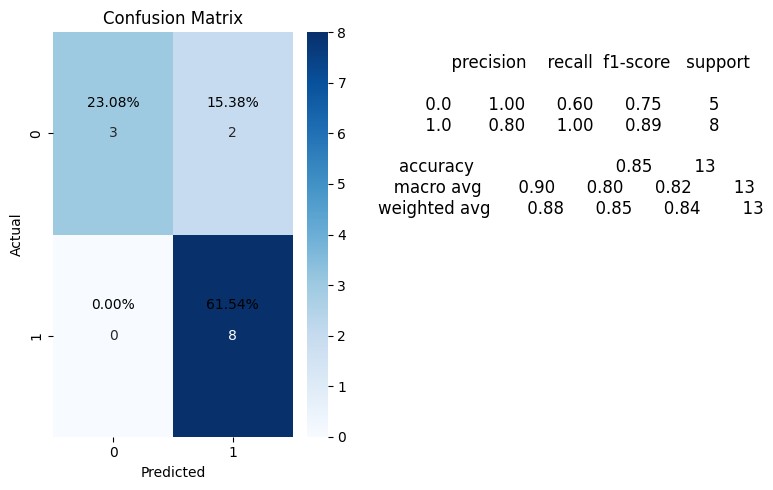

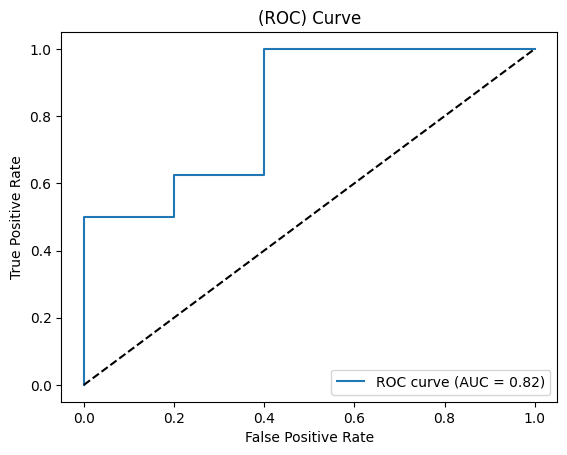

Support Vector Machine


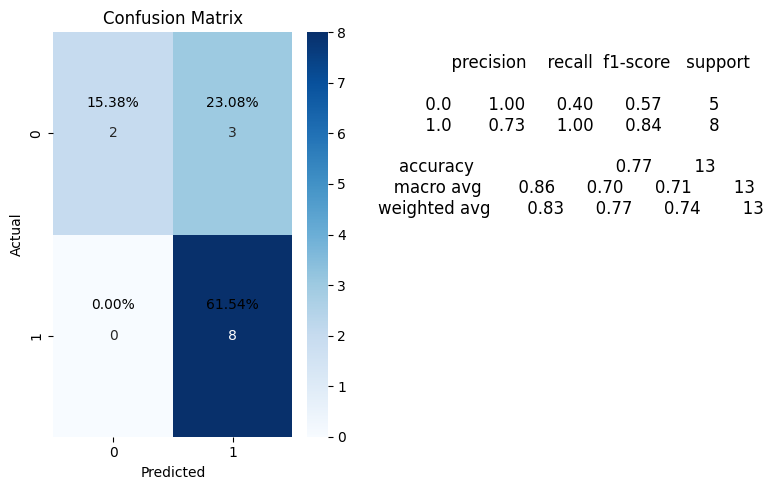

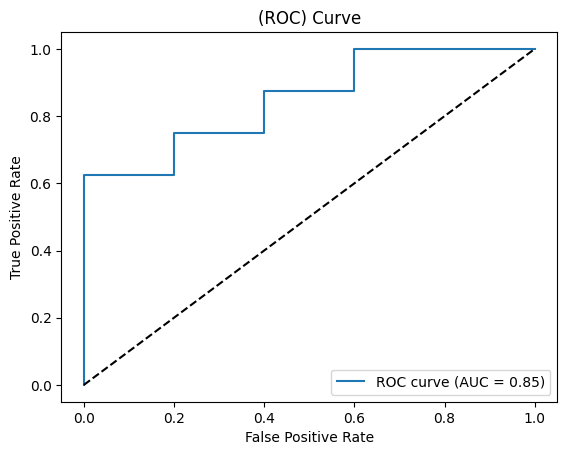

Gradient Boosting


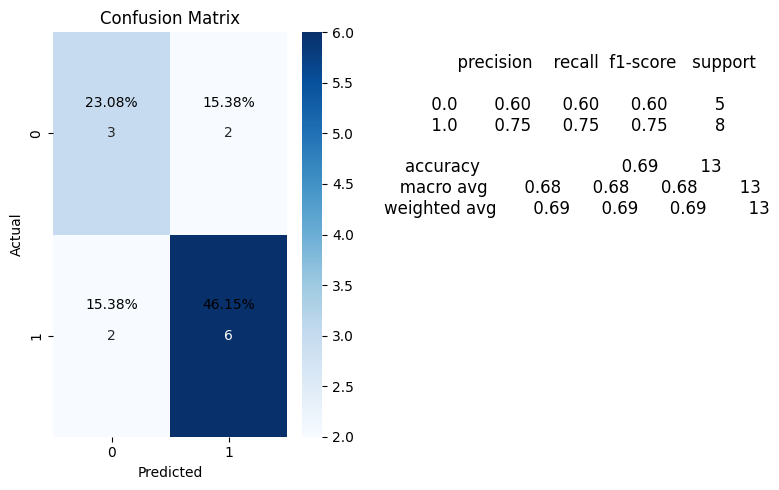

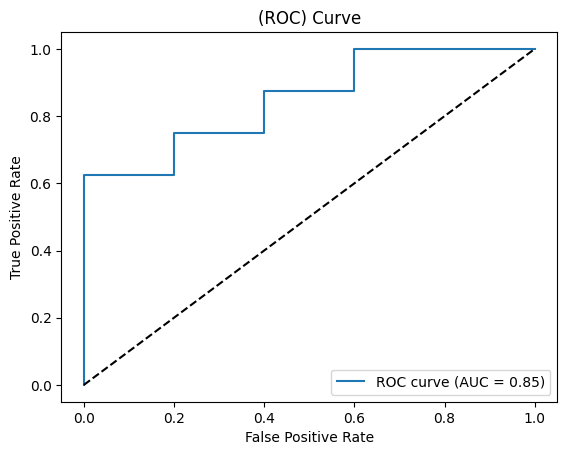

K-Nearest Neighbors


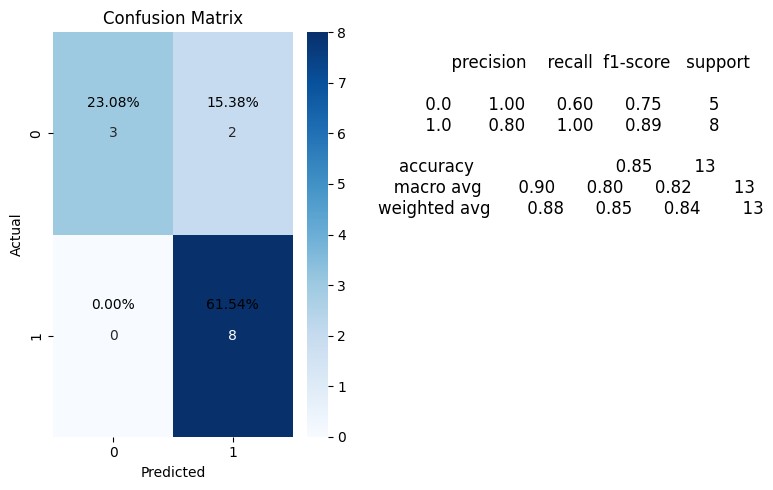

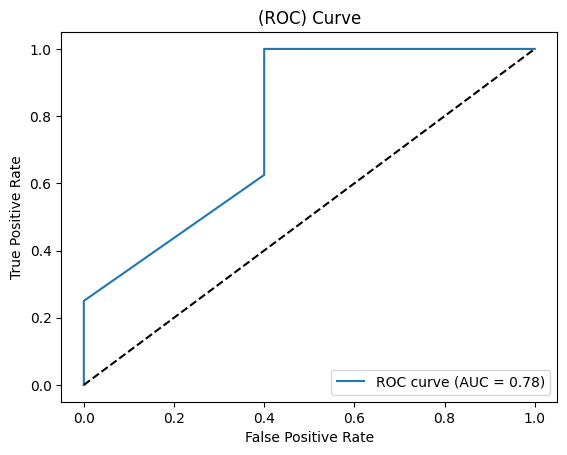

In [11]:
rfe_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=10000),
    'Support Vector Machine': SVC(random_state=42, kernel='linear', probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

for model_name, model in rfe_classifiers.items():
    print("\033[1m" + model_name + "\033[0m")
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    fs.plot_cfmatrix_report(y_test,predictions)
    fs.plot_auc_curve(model,x_test,y_test)
    

#### **RFE**
We will be running Recursive Feature Elimination (RFE) across various models, including **Random Forest**, **Logistic Regression**, **Support Vector Machine**, and **Gradient Boosting** to discern the optimal set of features for each. This involves systematically evaluating the performance of different feature subsets by testing varying numbers of features. Through the **RFE** process, we aim to identify not only the ideal number of features but also the specific attributes that contribute most significantly to the models' efficacy. By iteratively refining the feature selection, we seek to enhance the models' predictive power and streamline their performance with the most influential and relevant variables.

In [12]:
print("Final Features:")
print(x_train.columns)
min_features = 20


rfe_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=10000),
    'Support Vector Machine': SVC(random_state=42, kernel='linear'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
}
"""rfe_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42,max_iter=10000),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}"""


classifiers_features = {}

total_features = len(x_train.columns + '\n')

best_model_info = {}


for model_name, model in rfe_classifiers.items():
    print(f"\033[1mModel: {model_name}\033[0m")
    
    results = []

    for i in range(min_features, total_features):
        rfe = RFE(model, n_features_to_select=i)
        rfe.fit(x_train, y_train)
        
        selected_features = set(x_train.columns[rfe.support_])
        selected_features.add("tmid")
        selected_features.add("year")
        selected_features = list(selected_features)

        model.fit(x_train[selected_features], y_train)

        accuracy = model.score(x_test[selected_features], y_test)

        results.append((selected_features, accuracy))
    

    # Sort the results based on accuracy in descending order
    results = sorted(results, key=lambda x: x[1], reverse=True)

    classifiers_features[model_name] = results[0][0]
    best_model_info[model_name] = {'features': results[0][0], 'accuracy': results[0][1], 'model': model}
    
    # Print the results
    for features, accuracy in results[:1]:
        print("Selected Features:", features)
        print("Accuracy:" + str(accuracy) + '\n')

best_model_name = max(best_model_info, key=lambda k: best_model_info[k]['accuracy'])
best_model = best_model_info[best_model_name]['model']
best_features = best_model_info[best_model_name]['features']

print(f"\033[1mBest Model: {best_model_name}\033[0m")
print(f"Best Features: {best_features}")
print(f"Accuracy: {best_model_info[best_model_name]['accuracy']}\n")

Final Features:
Index(['year', 'tmid', 'player_awards', 'total_minutes', 'total_points',
       'total_assists', 'total_steals', 'total_blocks', 'total_turnovers',
       'total_pf', 'total_dq', 'total_gs', 'total_gp', 'total_fg_pct',
       'total_ft_pct', 'total_three_pct', 'total_orebounds_pct',
       'total_drebounds_pct', 'confid', 'rank', 'team_playoffs_count',
       'playoff_rank', 'winrate', 'po_winrate', 'coach_reg_wr', 'coach_po_wr',
       'coach_playoffs_count', 'coach_awards', 'team_rating',
       'team_players_rating'],
      dtype='object')
Model: Random Forest
Selected Features: ['team_players_rating', 'total_ft_pct', 'total_drebounds_pct', 'total_gs', 'total_blocks', 'total_minutes', 'coach_po_wr', 'team_rating', 'total_orebounds_pct', 'playoff_rank', 'coach_reg_wr', 'total_turnovers', 'total_assists', 'winrate', 'total_three_pct', 'total_fg_pct', 'tmid', 'total_gp', 'total_points', 'year', 'po_winrate']
Accuracy:0.6923076923076923

Model: Logistic Regression
Select

While applying a similar approach, we encountered a deviation when working with **K-Nearest Neighbors (KNN)**. Recursive Feature Elimination (RFE) wasn't conducive to the intricacies of KNN. To address this, we seamlessly pivoted to an alternative strategy, implementing **SelectKBest** for feature selection tailored to KNN's dynamics. 

In [13]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
results = []
knn = KNeighborsClassifier()
for i in range(min_features, total_features):
   

    selector = SelectKBest(score_func=mutual_info_classif, k=i)
    selector.fit(x_train, y_train)


    selected_features = set(x_train.columns[selector.get_support()])
    selected_features.add("tmid")
    selected_features.add("year")
    selected_features = list(selected_features)

    knn.fit(x_train[selected_features], y_train)

    accuracy = knn.score(x_test[selected_features], y_test)

    results.append((selected_features, accuracy))

results = sorted(results, key=lambda x: x[1], reverse=True)

classifiers_features["K-Nearest Neighbors"] = results[0][0]
rfe_classifiers["K-Nearest Neighbors"] = KNeighborsClassifier()
# Print the best 3 results
print(f"\033[1mModel: K-Nearest Neighbors\033[0m")
for features, accuracy in results[:1]:
    print("Selected Features:", features)
    print("Accuracy:" + str(accuracy) + '\n')



Model: K-Nearest Neighbors
Selected Features: ['team_players_rating', 'total_ft_pct', 'total_drebounds_pct', 'total_gs', 'total_blocks', 'total_minutes', 'coach_po_wr', 'team_rating', 'confid', 'total_orebounds_pct', 'playoff_rank', 'player_awards', 'coach_reg_wr', 'team_playoffs_count', 'total_turnovers', 'total_pf', 'total_assists', 'winrate', 'rank', 'total_three_pct', 'coach_playoffs_count', 'coach_awards', 'total_fg_pct', 'total_dq', 'total_steals', 'tmid', 'total_gp', 'total_points', 'year', 'po_winrate']
Accuracy:0.8461538461538461



#### **Grid Search**
Grid search is a hyperparameter optimization technique employed in machine learning to systematically evaluate and compare a predefined set of hyperparameter combinations. It operates by exhaustively searching through the specified grid of hyperparameter values, enabling a comprehensive exploration of the parameter space. This method is particularly beneficial when fine-tuning models, as it automates the process of hyperparameter selection, ensuring a rigorous examination of potential configurations. By systematically evaluating various combinations, grid search aids in identifying the optimal hyperparameter set that maximizes the model's performance metrics, contributing to enhanced predictive accuracy and generalization.

In [14]:
#best_params = fs.grid_search(classifiers_features,x_train,x_test,y_train,y_test)
#print(best_params)


best_params = {'Random Forest': {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}, 
    'Logistic Regression': {'C': 10, 'fit_intercept': True, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}, 
    'Gradient Boosting': {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}, 
    }


#### **Models Performance**

Choosing the model with the most promising results in the **tenth** year prompted us to scrutinize its performance across the entire temporal spectrum. We conducted a comprehensive assessment by testing the model on all available years and calculating the average accuracy. Recognizing that excelling in a single year may not be indicative of overall effectiveness, this method ensures a robust evaluation, considering the model's consistency and adaptability across diverse temporal contexts.

In [15]:
accuracy_scores = []
auc_scores = []
train_times = []
test_times = []
best_model = best_model_info[best_model_name]['model']
best_features = best_model_info[best_model_name]['features']
#print(best_model)

alg_results = {}
alg_times = {}
    
for model_name, model in rfe_classifiers.items():
    print("\033[1m" + model_name + "\033[0m")
    accuracy_scores = []
    auc_scores = []
    train_times = []
    test_times = []
    
   
    for test_year in range(3, 11): 
        x_train = merged_data[merged_data['year'].between(1, test_year - 1)].drop('playoff', axis=1)
        y_train = merged_data[merged_data['year'].between(1, test_year - 1)]['playoff']
        
        x_test = merged_data[merged_data['year'] == test_year].drop('playoff', axis=1)
        y_test = merged_data[merged_data['year'] == test_year]['playoff']
        
        # Training the model
        start_train = time.time()
        model.fit(x_train[classifiers_features[model_name]], y_train)
        end_train = time.time()
        
        start_test = time.time()
        predictions = model.predict(x_test[classifiers_features[model_name]])
        end_test = time.time()
        
        # Calculating accuracy
        accuracy = accuracy_score(y_test, predictions)
        accuracy_scores.append(accuracy)
        auc = roc_auc_score(y_test, predictions)
        auc_scores.append(auc)
        
        train_time = end_train - start_train
        test_time = end_test - start_test
        
        train_times.append(train_time)
        test_times.append(test_time)
        
        #print(f"Accuracy for testing year {test_year}: {accuracy}")
        #print(f"AUC for testing year {test_year}: {auc}")

    # Calculating average accuracy

    average_accuracy = sum(accuracy_scores) / len(accuracy_scores)
    average_auc = sum(auc_scores) / len(auc_scores)
    average_train_time = sum(train_times) / len(train_times)
    average_test_time = sum(test_times) / len(test_times)
    
    alg_results[model_name] = (average_accuracy,average_auc)
    alg_times[model_name] = (average_train_time,average_test_time)
    print(f"Average \033[1mAccuracy\033[0m across all years: {average_accuracy}")
    print(f"Average \033[1mAUC\033[0m across all years: {average_auc}")
    print("\n")


Random Forest
Average Accuracy across all years: 0.6825206043956044
Average AUC across all years: 0.6755208333333333


Logistic Regression
Average Accuracy across all years: 0.6964285714285714
Average AUC across all years: 0.6901041666666666


Support Vector Machine
Average Accuracy across all years: 0.6863839285714285
Average AUC across all years: 0.6729166666666666


Gradient Boosting
Average Accuracy across all years: 0.6760817307692307
Average AUC across all years: 0.6682291666666668


K-Nearest Neighbors
Average Accuracy across all years: 0.5634443681318682
Average AUC across all years: 0.5333333333333333




In [16]:

print("\033[1m" + "KAGGLE TEST YEAR" + "\033[0m")
x_train = merged_data[merged_data['year'].between(1, 10)].drop('playoff', axis=1)
y_train = merged_data[merged_data['year'].between(1, 10)]['playoff']

x_test = merged_data[merged_data['year'] == KAGGLE_TEST_YEAR].drop('playoff', axis=1)
y_test = merged_data[merged_data['year'] == KAGGLE_TEST_YEAR]['playoff']


model = LogisticRegression(random_state=42,max_iter=10000)
model_name = "Logistic Regression"

print("\033[1m" + model_name + "\033[0m")
team_map = {}
# KAGGLE_YEAR tmid with predictions
model.fit(x_train[classifiers_features[model_name]], y_train)
predictions = model.predict(x_test[classifiers_features[model_name]])

for(i,p) in enumerate(predictions):
    team_map[KAGGLE_YEAR.iloc[i]['tmid']] = p

#Teams to make playoffs
teams_1 = []
teams_0 = []

for team, status in team_map.items():
    if status == 1:
        teams_1.append(team)
    else:
        teams_0.append(team)

print("Teams to make playoffs:", teams_1)
print("Teams to not make playoffs:", teams_0)

print("\n")




KAGGLE TEST YEAR
Logistic Regression
Teams to make playoffs: ['ATL', 'IND', 'LAS', 'MIN', 'NYL', 'PHO', 'SAS', 'SEA', 'WAS']
Teams to not make playoffs: ['CHI', 'CON', 'TUL']




### **Algorithms Comparison**
To compare the performance of various algorithms, we'll assess metrics such as accuracy and AUC for predictive accuracy. Additionally, we'll evaluate training and test times to gauge computational efficiency. These metrics provide a comprehensive overview, considering both predictive power and computational speed, aiding in the selection of the most suitable algorithm for the task at hand.

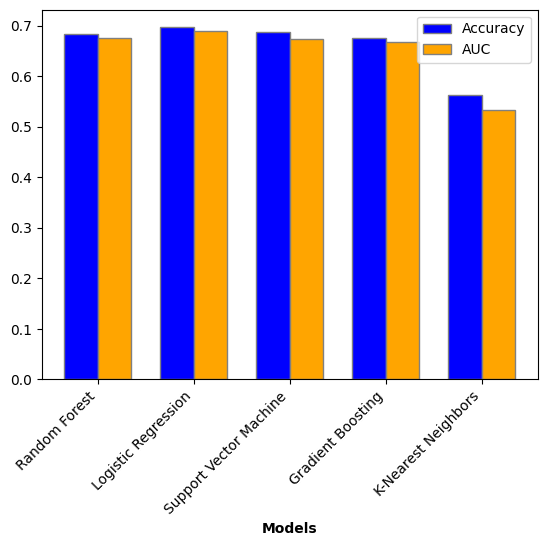

In [17]:
labels = list(alg_results.keys())
accuracy = [item[0] for item in alg_results.values()]
auc = [item[1] for item in alg_results.values()]

# Bar width
bar_width = 0.35

# Bar positions
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

# Creating bars with different colors
plt.bar(r1, accuracy, color='blue', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, auc, color='orange', width=bar_width, edgecolor='grey', label='AUC')

# Adding labels with diagonal rotation
plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels, rotation=45, ha='right')

# Adding legend
plt.legend()

# Show the plot
plt.show()

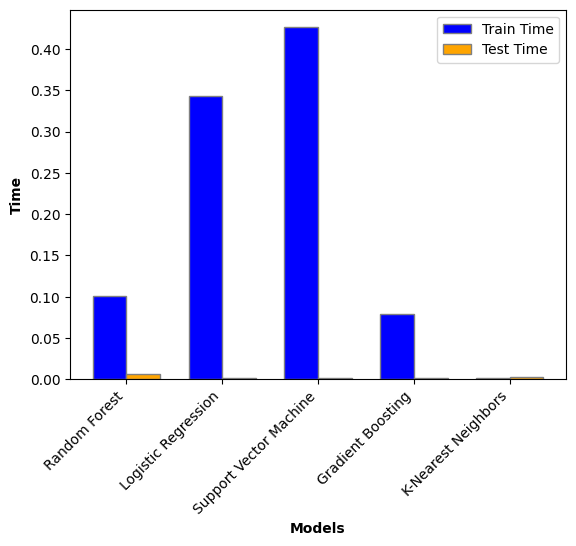

In [18]:
labels = list(alg_times.keys())
train_time = [item[0] for item in alg_times.values()]
test_time = [item[1] for item in alg_times.values()]

# Bar width
bar_width = 0.35

# Bar positions
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]

# Creating bars with different colors
plt.bar(r1, train_time, color='blue', width=bar_width, edgecolor='grey', label='Train Time')
plt.bar(r2, test_time, color='orange', width=bar_width, edgecolor='grey', label='Test Time')

# Adding labels with diagonal rotation
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Time', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(labels))], labels, rotation=45, ha='right')

# Adding legend
plt.legend()

# Show the plot
plt.show()